In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

2023-02-05 18:41:49.499498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 18:41:49.790328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 18:41:49.790400: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 18:41:51.417952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Data Preprocessing

In [2]:
# read dataset

dt = pd.read_csv('data_train.csv')
dt = dt.sample(frac=1)

dt

,tweet,label
885,NaN,NaN
1359,nasdem baper juga wak breok ya,tidak mendukung
1662,helmifelis goblok mu apdb jakarta itu aja an t...,tidak mendukung
1501,nasdem plin plan,hujatan
353,NaN,NaN
...,...,...
749,NaN,NaN
771,setuju sih kalau menggunakan akal sehat,hujatan
716,firli bahuri desak kasus formula naik ke peny...,dukungan
237,NaN,NaN


In [3]:
# delete NaN data
dt.dropna(inplace=True)

dt

,tweet,label
1359,nasdem baper juga wak breok ya,tidak mendukung
1662,helmifelis goblok mu apdb jakarta itu aja an t...,tidak mendukung
1501,nasdem plin plan,hujatan
1443,tatakujiyati fixtech anies baswedan klo gak ju...,hujatan
979,asmara1701 hhh jgn ngimpi malah partai nasdem...,tidak mendukung
...,...,...
423,asmara1701 para jendral2 arsitek rekayasa fs ...,hujatan
253,nasdem berikan otoritas penuh anies baswedan ...,dukungan
771,setuju sih kalau menggunakan akal sehat,hujatan
716,firli bahuri desak kasus formula naik ke peny...,dukungan


In [4]:
# update label

dt['label'] = dt['label'].replace({'pujian':'dukungan', 'hujatan':'tidak mendukung'})

## Data Preparation

dukungan           569
tidak mendukung    486
netral             181
Name: label, dtype: int64

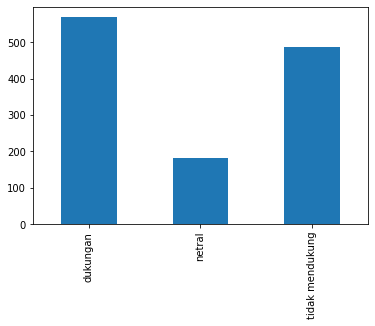

In [5]:
# visualize data

dt['label'].value_counts().sort_index().plot.bar()
dt['label'].value_counts()

# Oversampling

In [6]:
minority_class = 'netral'
num_samples_to_oversample = dt['label'].value_counts()['dukungan'] - dt['label'].value_counts()[minority_class]

In [7]:
minority_df = dt[dt['label'] == minority_class]

In [8]:
oversampled_df = minority_df.sample(num_samples_to_oversample, replace=True)


In [9]:
dt = pd.concat([dt, oversampled_df])

In [10]:
minority_class = 'tidak mendukung'
num_samples_to_oversample = dt['label'].value_counts()['dukungan'] - dt['label'].value_counts()[minority_class]

In [11]:
minority_df = dt[dt['label'] == minority_class]

In [12]:
oversampled_df = minority_df.sample(num_samples_to_oversample, replace=True)

In [13]:
dt = pd.concat([dt, oversampled_df])

tidak mendukung    569
dukungan           569
netral             569
Name: label, dtype: int64

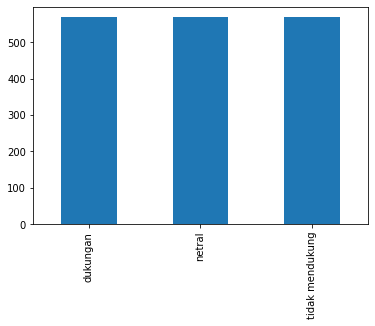

In [14]:
dt['label'].value_counts().sort_index().plot.bar()
dt['label'].value_counts()

In [15]:
# tokenizer text

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(dt['tweet'].values)
X = tokenizer.texts_to_sequences(dt['tweet'].values)
X = pad_sequences(X)
print(X)

[[   0    0    0 ... 2360 2361   23]
 [   0    0    0 ... 2363  593 1621]
 [   0    0    0 ...    3 2364 2365]
 ...
 [   0    0    0 ...    6  124 2248]
 [   0    0    0 ...  271  666  705]
 [   0    0    0 ...   11  854  467]]


In [16]:
# get label

y = pd.get_dummies(dt['label']).values
y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [17]:
print(y.shape)

(1707, 3)


In [18]:
# split dataset smote tanpa menggunakan tokenizing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(1365, 51)
(342, 51)


## Training Model

In [19]:
# LSTM Modelling

model = Sequential()
model.add(Embedding(5000, 256))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2023-02-05 18:41:56.028364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 18:41:56.028511: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-05 18:41:56.028612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-05 18:41:56.028707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-02-05 18:41:56.028833: W tensorfl

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm (LSTM)                 (None, None, 256)         525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
batch_size = 32
epochs = 100

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test))

Epoch 1/100
43/43 - 44s - loss: 1.0482 - accuracy: 0.4505 - val_loss: 0.9351 - val_accuracy: 0.5614 - 44s/epoch - 1s/step
Epoch 2/100
43/43 - 28s - loss: 0.6181 - accuracy: 0.7487 - val_loss: 0.7839 - val_accuracy: 0.7515 - 28s/epoch - 660ms/step
Epoch 3/100
43/43 - 28s - loss: 0.2365 - accuracy: 0.9172 - val_loss: 0.5995 - val_accuracy: 0.7661 - 28s/epoch - 662ms/step
Epoch 4/100
43/43 - 29s - loss: 0.0985 - accuracy: 0.9656 - val_loss: 0.6597 - val_accuracy: 0.7749 - 29s/epoch - 681ms/step
Epoch 5/100
43/43 - 29s - loss: 0.0504 - accuracy: 0.9832 - val_loss: 0.7957 - val_accuracy: 0.7836 - 29s/epoch - 681ms/step
Epoch 6/100
43/43 - 30s - loss: 0.0348 - accuracy: 0.9897 - val_loss: 0.7981 - val_accuracy: 0.7632 - 30s/epoch - 690ms/step
Epoch 7/100
43/43 - 30s - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.9011 - val_accuracy: 0.8012 - 30s/epoch - 689ms/step
Epoch 8/100
43/43 - 31s - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.8870 - val_accuracy: 0.8070 - 31s/epoch - 715ms/step
Epo

Epoch 67/100
43/43 - 16s - loss: 0.0030 - accuracy: 0.9985 - val_loss: 1.4474 - val_accuracy: 0.7602 - 16s/epoch - 361ms/step
Epoch 68/100
43/43 - 16s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 1.4697 - val_accuracy: 0.7602 - 16s/epoch - 361ms/step
Epoch 69/100
43/43 - 16s - loss: 0.0036 - accuracy: 0.9985 - val_loss: 1.4912 - val_accuracy: 0.7573 - 16s/epoch - 365ms/step
Epoch 70/100
43/43 - 16s - loss: 0.0033 - accuracy: 0.9985 - val_loss: 1.5121 - val_accuracy: 0.7573 - 16s/epoch - 376ms/step
Epoch 71/100
43/43 - 16s - loss: 0.0034 - accuracy: 0.9985 - val_loss: 1.5351 - val_accuracy: 0.7602 - 16s/epoch - 363ms/step
Epoch 72/100
43/43 - 16s - loss: 0.0031 - accuracy: 0.9985 - val_loss: 1.5294 - val_accuracy: 0.7602 - 16s/epoch - 382ms/step
Epoch 73/100
43/43 - 19s - loss: 0.0399 - accuracy: 0.9868 - val_loss: 1.5077 - val_accuracy: 0.7251 - 19s/epoch - 433ms/step
Epoch 74/100
43/43 - 19s - loss: 0.0491 - accuracy: 0.9875 - val_loss: 1.2886 - val_accuracy: 0.7573 - 19s/epoch - 439

In [ ]:
# save model into file .h5

model.save('sentiment_analysis.h5')

In [22]:
# Mengambil data dari history pelatihan model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [23]:
# Membuat plot
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

<Figure size 864x360 with 0 Axes>

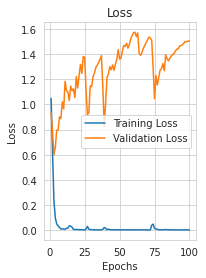

In [24]:
plt.subplot(1,2,1)
sns.lineplot(x=range(1,epochs+1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1,epochs+1), y=val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

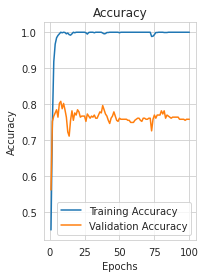

In [25]:
plt.subplot(1,2,2)
sns.lineplot(x=range(1,epochs+1), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1,epochs+1), y=val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

11/11 [==============================] - 1s 66ms/step
              precision    recall  f1-score   support

           0       0.65      0.84      0.73       116
           1       0.83      0.93      0.88       107
           2       0.86      0.52      0.65       119

    accuracy                           0.76       342
   macro avg       0.78      0.76      0.75       342
weighted avg       0.78      0.76      0.75       342



In [27]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

[[ 97  10   9]
 [  6 100   1]
 [ 46  11  62]]


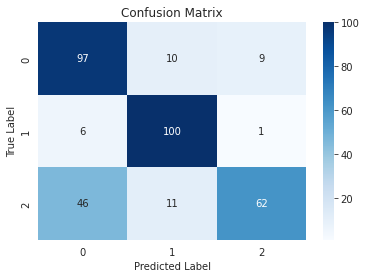

In [28]:
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Evaluate Model

In [29]:
# evaluate model with data test

score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

11/11 - 1s - loss: 1.5046 - accuracy: 0.7573 - 693ms/epoch - 63ms/step
score: 1.50
acc: 0.76


## Predict New Dataset

In [58]:
# read new dataset
import re
import numpy as np
import pandas as pd
data = pd.read_csv('tweet2.csv')
# menghapus kolom id
data = data.drop(['id'], axis=1)

data

,tweet
0,"@M45Broo_ Cebong benar2 panik luar biasa, ini ..."
1,@Relawananies https://t.co/uf5sE0iGLI
2,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
3,RT @aLy_Bima: Video ini hanya untuk orang yang...
4,"RT @tempodotco: ""Tidak ringan permasalahan di ..."
...,...
445,RT @Relawananies: Momen haru saat Anies Baswed...
446,@maspiyuaja Terima kasih om https://t.co/PUgr2...
447,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
448,RT @OposisiCerdas: Kamhar Lakumani Sebut Anies...


In [59]:
# data preprocessing

def tweetPrepocessing(text):
  text = text.lower()
  text = re.sub('\n','', text)
  text = re.sub('rt ','', text)
  text = re.sub('#','', text)
  text = re.sub('@\w+(?:\:)\ ','', text)
  text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+','', text)
  text = re.sub('[^a-zA-z0-9\s]','', text)
  text = re.sub('  ',' ', text)

  if text == ' ':
    return None

  return text

data = data.sample(frac=1)
data['tweet'] = data['tweet'].apply(tweetPrepocessing)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace = True)

data

,tweet
0,wahhhaneksasi itu
1,indonesiamemanggil 5 tahun anies baswedan memi...
2,awas kena diare lagi om
3,anies baswedan duduk bareng elite parpol pks k...
4,kwekkwek
...,...
430,kwekkwek
431,bapak christoforus rea tokoh ummat katolik nam...
432,sejak kemarin anies baswedan bukan lagi gubern...
433,video ini hanya untuk orang yang belum tahu pr...


In [60]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X)
print(X)


tokenizer.fit_on_texts(data['tweet'].values)

X_new = tokenizer.texts_to_sequences(data['tweet'].values)
X_new = pad_sequences(X_new)
X_new.shape

[[   0    0    0 ...    0  631   47]
 [   0    0    0 ...   41   42   43]
 [   0    0    0 ...  632   79  427]
 ...
 [   0    0    0 ...   51    7  265]
 [   0    0    0 ...   45    1    2]
 [   0    0    0 ...  150  220 1549]]


(435, 42)

In [61]:
# load model
from keras.models import Sequential, load_model
mymodel = load_model('sentiment_analysis.h5')

In [64]:
# predict data

pred = mymodel.predict(X_new)


14/14 [==============================] - 1s 50ms/step


NameError: name 'y_pred' is not defined

In [53]:
# labelling

def labelling(array):
  labels = ['dukungan', 'netral', 'tidak mendukung']
  output = []
  for a in array:
    output.append(labels[np.argmax(a)])
  return output

label = labelling(pred)

In [54]:
# add label to data

data['label'] = label

data

,tweet,label
0,kenduri rakyat jarnas anies baswedan yogyakart...,netral
1,brengsek anies baswedan gak bisa kerja sekaran...,netral
2,hanya pandai omdo ajakelebihan bayar dn php,netral
3,ketum partai gerindra prabowo subianto memilik...,tidak mendukung
4,indonesiamemanggil 5 tahun anies baswedan memi...,tidak mendukung
...,...,...
430,sinyal buat koalisi ak2412 oktoober 2022jender...,netral
431,janji anies baswedan menjadi jancukkepulauan b...,dukungan
432,kenapa disaat last lap pencitraan,tidak mendukung
433,partai koalisi pemerintah 82 suaranya di parle...,dukungan


In [43]:
# save to new csv

data.to_csv('tweet2_new.csv', index=False)